## Show difference between 3 subjects in keyboard dataset

In [14]:
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from skbio import TreeNode
from friendly_guacamole.datasets import DietInterventionStudy
from friendly_guacamole.transforms import Rarefaction, CLR, AsDense, UniFrac, \
    RarefactionBIOM
from q2_anomaly_detection.benchmark import Benchmark, ColumnValueSplitter, ExternalScorer
from q2_anomaly_detection.utils import as_dense, TrivialScorer
%matplotlib inline
from gemelli.rpca import rpca
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer

In [5]:
RANDOM_SEED = 825
RAREFACTION_DEPTH = 1000

In [6]:
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = DietInterventionStudy('data/diet_intervention')

Files already downloaded and verified


In [40]:
class RPCA(BaseEstimator):
    def __init__(self, n_components=2):
        self.n_components = n_components

    def fit(self, X, y=None):
        self.ordination, distances = rpca(X, n_components=self.n_components)
        self.embedding_ = self.ordination.samples
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.embedding_
    
    def transform(self, X):
        pass
    

In [8]:
baseline = Pipeline(steps=[
    ('asdense', AsDense()),
    ('baseline', TrivialScorer()),
])
iso = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('IF', IsolationForest(contamination="auto")),
])
lof = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm = Pipeline(steps=[
    ('asdense', AsDense()),
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

iso_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('IF', IsolationForest(contamination="auto")),
])
lof_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm_clr = Pipeline(steps=[
    ('asdense', AsDense()),
    ('clr', CLR()),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

In [9]:
# CONVENTION: anomaly scores should be transformed onto (0, 1) where 1 is
#  least anomalous and 0 is the most anomalous
models = {
    'baseline': {
        'model': baseline,
    },
    'IF': {
        'model': iso,
    },
    'LOF': {
        'model': lof,
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
    },
    'ocsvm': {
        'model': ocsvm,
    },
    'IF-clr': {
        'model': iso_clr,
    },
    'LOF-clr': {
        'model': lof_clr,
    },
    'LOF-jaccard-clr': {
        'model': lof_jaccard_clr,
    },
    'ocsvm-clr': {
        'model': ocsvm_clr,
    },
}

In [10]:
table = dataset['table']
tree = tree_path = dataset.apply('tree', 'path')

In [11]:
pca = RPCA()
P = pca.fit_transform(table)

In [ ]:
table.shape

In [16]:
metadata_all = dataset['metadata']

In [17]:
def construct_category(metadata):
    metadata['host_subject_id_for_plant'] = np.nan
    plant_samples = metadata.index[metadata.diet == 'Plant']
    metadata.loc[:, 'host_subject_id_for_plant'].loc[plant_samples] = metadata.host_subject_id[
        plant_samples].to_numpy()
    
    metadata['diet_for_subsample'] = np.nan
    keep_diet_indices = metadata['diet'].sample(len(metadata) // 2).index
    metadata.loc[:, 'diet_for_subsample'].loc[keep_diet_indices] = metadata.diet[keep_diet_indices].to_numpy()


def subset_metadata(metadata_all, table):
    table_ids = set(table.ids())

    # also remove anything that does not have more than RAREFACTION_DEPTH counts
    #  in both 'Plant' and 'Meat'
    table_sum = table.sum(axis='sample')

    insufficient_count_ids = table.ids('sample')[table_sum < RAREFACTION_DEPTH]

    table_ids -= set(insufficient_count_ids)


    metadata = metadata_all.query('host_common_name == "human" & sample_name in @table_ids &'
                                  'diet in ["Plant", "Animal"]'
                                 )
    
    diets_present = metadata[['host_subject_id', 'diet']].groupby('host_subject_id').agg(set)
    diets_sufficient = diets_present.apply(lambda diets: diets >= {'Plant', 'Animal'})
    sufficient_ids = diets_sufficient.loc[diets_sufficient['diet']].index
    
    metadata = metadata.query('host_subject_id in @sufficient_ids')

    return metadata

In [18]:
metadata = subset_metadata(metadata_all, table)

metadata = metadata.set_index('sample_name')

In [19]:
# TRAINING_CATEGORY = 'host_subject_id_for_plant'
# TRUTH_CATEGORY = 'host_subject_id'
# INTEREST_VARIABLE = 'diet'


TRAINING_CATEGORY = 'diet_for_subsample'
TRUTH_CATEGORY = 'diet'
INTEREST_VARIABLE = 'diet'

In [20]:
metadata[INTEREST_VARIABLE].unique()


array(['Plant', 'Animal'], dtype=object)

In [21]:
construct_category(metadata)

/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
table.filter(metadata.index, axis='sample')

7107 x 210 <class 'biom.table.Table'> with 161609 nonzero entries (10% dense)

In [23]:
np.random.seed(RANDOM_SEED)
subtable = table  # table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [24]:
subtable.shape

(7107, 210)

In [25]:
study_ids = subtable.ids('sample')

/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03205195769589151 and the largest is 4.700462202924698.
  warn(
/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


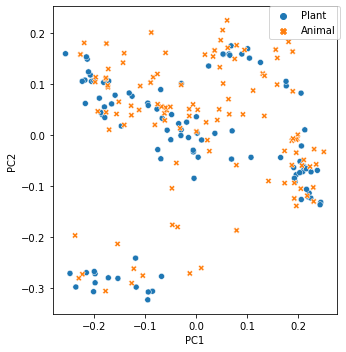

In [26]:
# rarefied_table = Rarefaction(RAREFACTION_DEPTH).fit_transform(as_dense(subtable).astype(int))
# dm = pdist(rarefied_table, metric='jaccard')
# table_for_pcoa = CLR().fit_transform(as_dense(subtable))
# dm = pdist(table_for_pcoa, metric='euclidean')
dm = Pipeline(
    [
        ('rarefy', RarefactionBIOM(RAREFACTION_DEPTH)),
        ('unifrac', UniFrac(tree_path)),
    ]
).fit_transform(subtable)

pcoa_results = pcoa(dm)

pcoa_results.samples.index = study_ids

pcoa_with_metadata = pcoa_results.samples.join(metadata)

plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue=TRUTH_CATEGORY,
                     style=INTEREST_VARIABLE,
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.savefig('results/clr-pcoa.png')
plt.tight_layout()

In [ ]:
pca = Pipeline([
    ("RPCA", RPCA()),
    ("select", ColumnTransformer(
        [("PC", "passthrough", ["PC1"])]
    ))
])
P = pca.fit_transform(subtable)
sns.scatterplot(
    x=P[:, 0],
    y=1,
    hue=submetadata.loc[subtable.ids()]["host_subject_id"]
)

## Show the results of an anomaly detection algorithm of one class v. rest


In [27]:
submetadata.shape

(210, 43)

In [28]:
submetadata.groupby([TRUTH_CATEGORY, 'diet']).agg('count')


,,collection_date_publication,collection_time,collection_timestamp,country,day,description,elevation,empo_1,empo_2,empo_3,...,qiita_study_id,sample_type,scientific_name,sex,subjdiet,subjectfood,taxon_id,title,host_subject_id_for_plant,diet_for_subsample
diet,diet,,,,,,,,,,,,,,,,,,,,,
Animal,Animal,111,93,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,0,47
Plant,Plant,99,74,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,58


In [29]:
splitter = ColumnValueSplitter(TRAINING_CATEGORY, TRUTH_CATEGORY)
external_scorer = ExternalScorer()
benchmark = Benchmark(models)
benchmark.set_scorer(external_scorer)
benchmark.set_splitter(splitter)
all_results = benchmark.benchmarking_loop(subtable, submetadata)

/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was

In [30]:
res_df = all_results.long_form()

In [31]:
res_with_pc = res_df.reset_index().join(
    pcoa_results.samples[['PC1', 'PC2', 'PC3']], on='sample_id'
).join(
    metadata[[INTEREST_VARIABLE]], on='sample_id'
)

In [32]:
pd.set_option("display.max_rows", 101)
all_results.short_form().sort_values('avg_prec', ascending=False)


,model_name,category,roc_auc,avg_prec
8,ocsvm,Plant,0.767633,0.871775
17,ocsvm-clr,Animal,0.714804,0.829921
13,LOF-clr,Animal,0.662879,0.800683
11,IF-clr,Animal,0.661774,0.777551
6,LOF-jaccard,Plant,0.539662,0.751375
14,LOF-jaccard-clr,Plant,0.500000,0.730263
0,baseline,Plant,0.500000,0.730263
4,LOF,Plant,0.470226,0.711248
16,ocsvm-clr,Plant,0.429356,0.705605
3,IF,Animal,0.570234,0.694231


/home/kalen/miniconda3/envs/q2-anomaly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


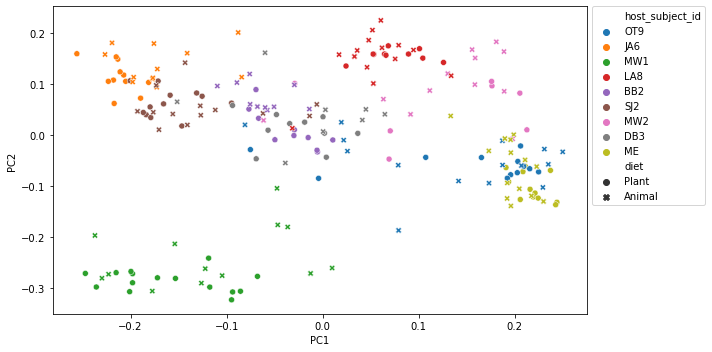

In [33]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style=INTEREST_VARIABLE,
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()

In [34]:
sns.set(font_scale=1.5)

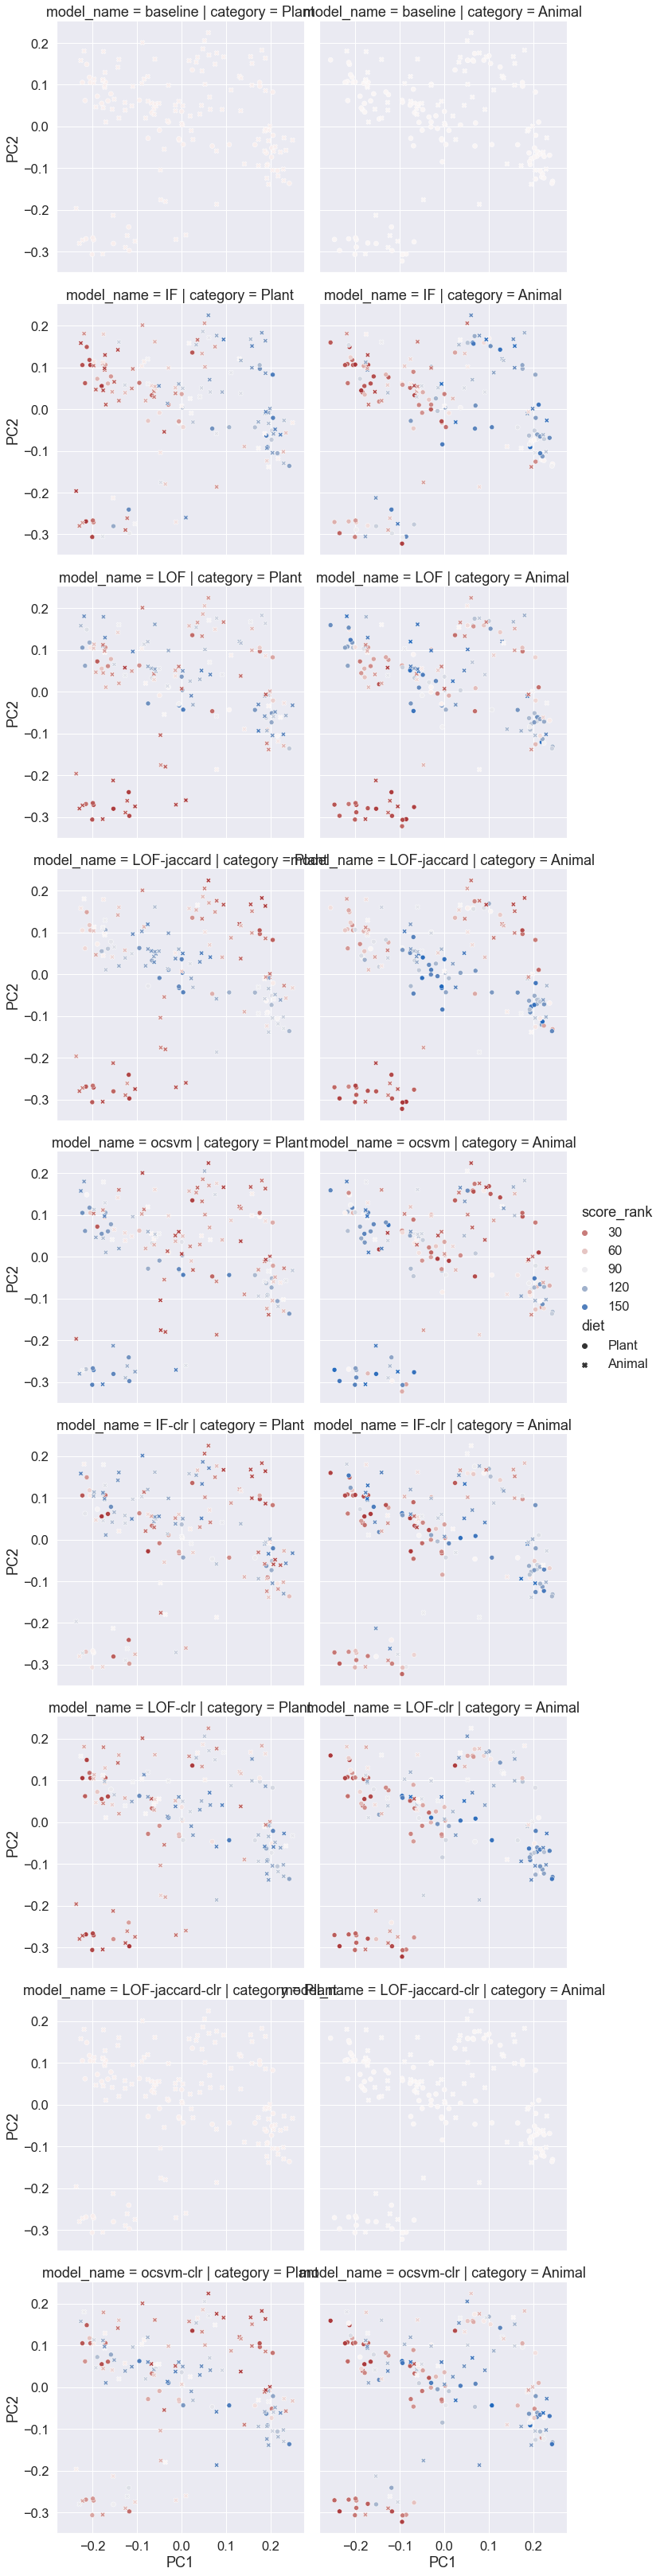

In [35]:
ax = sns.relplot(x='PC1', y='PC2',
            data=res_with_pc,
            col='category',
            row='model_name',
            hue='score_rank',
            palette='vlag_r',
            style=INTEREST_VARIABLE,
            aspect=1,
           )



In [80]:
sample_id = "JA6"
indivduals_ids = submetadata.loc[submetadata["host_subject_id"] == sample_id].index
individual_table = subtable.filter(indivduals_ids, inplace=False)

<AxesSubplot:>

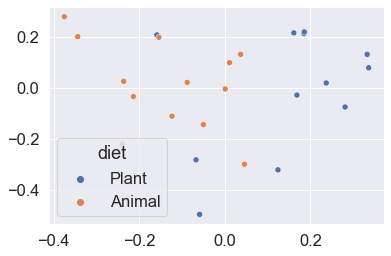

In [49]:
pca = Pipeline([
    ("RPCA", RPCA()),
    ("select", ColumnTransformer(
        [("PC", "passthrough", ["PC1", "PC2"])]
    ))
])
P = pca.fit_transform(individual_table)
sns.scatterplot(
    x=P[:, 0],
    y=P[:, 1],
    hue=submetadata.loc[individual_table.ids()]["diet"]
)

<AxesSubplot:>

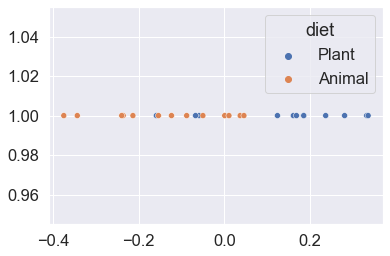

In [50]:
pca = Pipeline([
    ("RPCA", RPCA()),
    ("select", ColumnTransformer(
        [("PC", "passthrough", ["PC1", "PC2"])]
    ))
])
P = pca.fit_transform(individual_table)
sns.scatterplot(
    x=P[:, 0],
    y=1,
    hue=submetadata.loc[individual_table.ids()]["diet"]
)

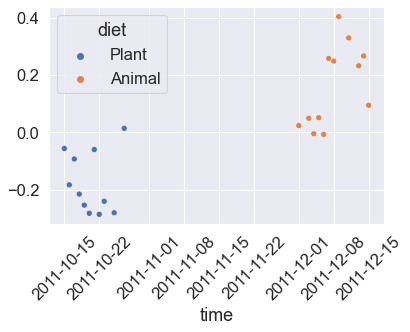

In [81]:
pca = Pipeline([
    ("RPCA", RPCA()),
    ("select", ColumnTransformer(
        [("PC", "passthrough", ["PC1", "PC2"])]
    ))
])
P = pca.fit_transform(individual_table)
g = sns.scatterplot(
    x=submetadata.loc[individual_table.ids()]["time"],
    y=P[:, 0],
    hue=submetadata.loc[individual_table.ids()]["diet"]
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.xticks(rotation=45)
plt.show()

In [92]:
metadata.loc[metadata["host_subject_id"] == "JA6"]

,collection_date_publication,collection_time,collection_timestamp,country,day,description,diet,elevation,empo_1,empo_2,...,qiita_study_id,sample_type,scientific_name,sex,subjdiet,subjectfood,taxon_id,title,host_subject_id_for_plant,diet_for_subsample
sample_name,,,,,,,,,,,,,,,,,,,,,
11550.DD116,10.18.2011,1000,2011-10-18,USA,1.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,NaN
11550.DD119,10.20.2011,1200,2011-10-20,USA,3.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,NaN
11550.DD135,10.22.2011,2300,2011-10-22,USA,5.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,NaN
11550.DD140,10.23.2011,2300,2011-10-23,USA,6.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,Plant
11550.DD141,10.19.2011,1800,2011-10-19,USA,2.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,NaN
11550.DD157,10.27.2011,8_00am,2011-10-27,USA,10.0,Dhaka_redos,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,Plant
11550.DD168,10.21.2011,6am,2011-10-21,USA,4.0,Inuit_and_dhaka_redos2,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,Plant
11550.DD30,10.17.2011,1200,2011-10-17,USA,0.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,NaN
11550.DD48,10.25.2011,700,2011-10-25,USA,8.0,Dhaka_diet_batch1,Plant,5,Host-asssociated,Animal-associated,...,11550,feces,human gut metagenome,not provided,Plant-10,10,408170,Diet rapidly and reproducibly alters the human...,JA6,Plant


KeyError: False

In [72]:
pd.to_datetime(metadata.collection_date_publication.replace({"12.13/14.2011": "12.13.2011"}))

sample_name
11550.DD10    2011-10-14
11550.DD102   2011-10-22
11550.DD104   2011-10-22
11550.DD106   2011-10-21
11550.DD107   2011-10-22
                 ...    
11550.ID92    2011-12-02
11550.ID95    2011-12-01
11550.ID97    2011-12-12
11550.ID98    2011-12-09
11550.ID99    2011-12-07
Name: collection_date_publication, Length: 210, dtype: datetime64[ns]

In [73]:
submetadata["time"] = pd.to_datetime(metadata.collection_date_publication.replace({"12.13/14.2011": "12.13.2011"}))

In [74]:
submetadata["time"]

sample_name
11550.DD10    2011-10-14
11550.DD102   2011-10-22
11550.DD104   2011-10-22
11550.DD106   2011-10-21
11550.DD107   2011-10-22
                 ...    
11550.ID92    2011-12-02
11550.ID95    2011-12-01
11550.ID97    2011-12-12
11550.ID98    2011-12-09
11550.ID99    2011-12-07
Name: time, Length: 210, dtype: datetime64[ns]